# Analize results

In [1]:
import supportFiles.myFunc as myF
import pandas as pd
import numpy as np
import math
import os
import re
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
%matplotlib inline

### Function to change table layout

In [2]:
filepath = "./dissertation/"

def load_errors_per_model(filename: str, filepath: str=filepath) -> pd.DataFrame:
    test = pd.read_csv(filepath+filename, sep=',')
    to_concat = []
    error_types = ["TN", "FP", "FN", "TP"]
    for model in [x.split()[0] for x in test.columns if "TP" in x]:
        cols = [model + " " + x for x in error_types]
        temp = test.loc[:, test.columns.isin(["Data Set"] + cols)].rename(columns=dict(zip(cols, error_types)))
        temp["Model"] = model
        to_concat.append(temp)

    return pd.concat(to_concat, axis=0, ignore_index=True)

### Get data from all targets and source models

In [10]:
temp = []

# Get all result files "fscore_b_SCAN_*.csv"
files = [s for s in os.listdir(filepath) if ("fscore_b_SCAN" in s and s.endswith(".csv"))]
for file in files:
    # add information to be concatenated
    temp.append(load_errors_per_model(file))
    # find us/os or no sampling tag
    temp[-1]["sampling"] = re.search(r"CIC_?([^_]*)\.csv", file).group(1)
    # name source from filename
    temp[-1]["origin"] = file.split("_")[3]

# Join as single dataframe
data = pd.concat(temp, names=["lero"], ignore_index=True)
# Drop unnamed column
if "Unnamed: 0" in data.columns:
    data.drop(["Unnamed: 0"], axis=1, inplace=True)
# Rename Data Set as Target to clarify
data.rename(columns={"Data Set": "Target"}, inplace=True)

data

,Target,TN,FP,FN,TP,Model,sampling,origin
0,SCAN_NB15_CIC,21093.0,15582.0,247.0,154.0,DT,,AB-TRAP
1,SCAN_CIC-IDS_CIC,1544295.0,726827.0,158164.0,640.0,DT,,AB-TRAP
2,SCAN_ToN-IoT_CIC,1707077.0,806982.0,20225.0,15980.0,DT,,AB-TRAP
3,SCAN_BoT-IoT_CIC,81538.0,7696.0,3373746.0,139664.0,DT,,AB-TRAP
4,SCAN_internet_CIC,9129714.0,2639.0,82298.0,3238.0,DT,,AB-TRAP
...,...,...,...,...,...,...,...,...
535,SCAN_AB-TRAP_CIC,8692629.0,439724.0,158921.0,3102.0,XGB,us,ToN-IoT
536,SCAN_NB15_CIC,25709.0,10966.0,308.0,93.0,XGB,us,ToN-IoT
537,SCAN_CIC-IDS_CIC,1072085.0,1199037.0,156186.0,2618.0,XGB,us,ToN-IoT
538,SCAN_BoT-IoT_CIC,82927.0,6307.0,1694249.0,1819161.0,XGB,us,ToN-IoT


### Corrections

- Remove tags from target's name
- Update to current names for AB-TRAP data sets

In [11]:
data["Target"] = data.Target.apply(lambda x: re.search(r"SCAN_?([^_]*)_CIC", x).group(1))
data["Target"] = data.Target.replace({'internet': 'WAB-TRAP', 'AB-TRAP': 'LAB-TRAP'})
data["origin"] = data.origin.replace({'internet': 'WAB-TRAP', 'AB-TRAP': 'LAB-TRAP'})
data.head(10)

,Target,TN,FP,FN,TP,Model,sampling,origin
0,NB15,21093.0,15582.0,247.0,154.0,DT,,LAB-TRAP
1,CIC-IDS,1544295.0,726827.0,158164.0,640.0,DT,,LAB-TRAP
2,ToN-IoT,1707077.0,806982.0,20225.0,15980.0,DT,,LAB-TRAP
3,BoT-IoT,81538.0,7696.0,3373746.0,139664.0,DT,,LAB-TRAP
4,WAB-TRAP,9129714.0,2639.0,82298.0,3238.0,DT,,LAB-TRAP
5,NB15,36675.0,0.0,401.0,0.0,LR,,LAB-TRAP
6,CIC-IDS,953125.0,1317997.0,1363.0,157441.0,LR,,LAB-TRAP
7,ToN-IoT,2514059.0,0.0,36205.0,0.0,LR,,LAB-TRAP
8,BoT-IoT,50941.0,38293.0,2686426.0,826984.0,LR,,LAB-TRAP
9,WAB-TRAP,9126543.0,5810.0,85536.0,0.0,LR,,LAB-TRAP


### Helper class distribution set

In [99]:
#setInfo = pd.DataFrame(index=myF.datasetOptions().values())
data.rename(columns={'Data Set':'target'}, inplace=True)
#data.set_index('target', inplace=True)
setInfo = pd.DataFrame(data={'name':['LAB-TRAP', 'NB15', 'CIC-IDS', 'ToN-IoT', 'BoT-IoT', 'WAB-TRAP'],
                             'scan':[162023,401, 158804, 36205, 3513410, 85536],
                             'benign':[9132353, 36675, 2271122, 2514059, 89234, 9132353],
                             'total':[9294376,  38987, 2827677, 5350583, 13427569, 9217889]})
setInfo.set_index('name',inplace=True)
setInfo['scan_ratio'] = setInfo.apply(lambda x: 100*x['scan']/(x['scan']+x['benign']), axis=1)
setInfo
#data={'AB-TRAP':[162023, 9132353, 9294376], 'NB15':[401, 36675, 38987], 'CIC-IDS':[158804, 2271122, 2827677],'ToN-IoT':[36205, 2514059, 5350583], 'BoT-IoT':[3513410, 89234, 13427569], 'internet':[85536, 9132353, 9217889]},

,scan,benign,total,scan_ratio
name,,,,
LAB-TRAP,162023,9132353,9294376,1.743237
NB15,401,36675,38987,1.081562
CIC-IDS,158804,2271122,2827677,6.535343
ToN-IoT,36205,2514059,5350583,1.419657
BoT-IoT,3513410,89234,13427569,97.523097
WAB-TRAP,85536,9132353,9217889,0.927935


In [105]:
tb = setInfo.pivot_table(values="scan_ratio", columns="name")
with open(filepath+"table_scan_ratio.tex", "w") as f:
    f.write(tb.to_latex(index=False, float_format="%.3f", na_rep="-", caption="Percentage of malicious traffic in the data set", label="tab:scan_ratio", position="H"))

### Get MCC function

In [13]:
def mcc(x: pd.DataFrame, debug: bool=False) -> float:
  '''
      Calculate MCC from coefficients of a confusion matrix.
  '''
  Ts = x[["TN","TP"]].to_numpy()
  Fs = x[["FN","FP"]].to_numpy()
  if len(Ts.shape) == 1:
    Ts = Ts.reshape(1,-1)
    Fs = Fs.reshape(1,-1)

  if debug:
    print(Ts)
    print(Ts)
    print(Ts.prod() - Fs.prod())
    print((Ts + Fs.T))
    print((Ts + Fs.T).prod())

  temp = (Ts + Fs.T).prod()
  return (Ts.prod() - Fs.prod())/np.sqrt(temp) if temp else .0

# Test from example in wikipedia
mcc(pd.DataFrame([[6,1,2,3]], columns=["TP", "FP", "FN", "TN"]))

0.47809144373375745

### Set new column for MCC per model, source, sampling and target

In [14]:
data["MCC"] = data.apply(mcc, axis=1)
data.head()

,Target,TN,FP,FN,TP,Model,sampling,origin,MCC
0,NB15,21093.0,15582.0,247.0,154.0,DT,,LAB-TRAP,-0.008544
1,CIC-IDS,1544295.0,726827.0,158164.0,640.0,DT,,LAB-TRAP,-0.170527
2,ToN-IoT,1707077.0,806982.0,20225.0,15980.0,DT,,LAB-TRAP,0.030464
3,BoT-IoT,81538.0,7696.0,3373746.0,139664.0,DT,,LAB-TRAP,-0.036483
4,WAB-TRAP,9129714.0,2639.0,82298.0,3238.0,DT,,LAB-TRAP,0.142696


### Choose one model type

In [15]:
chosen_model = "DT"

In [16]:
setInfo.scan_ratio

name
LAB-TRAP     1.743237
NB15         1.081562
CIC-IDS      6.535343
ToN-IoT      1.419657
BoT-IoT     97.523097
WAB-TRAP     0.927935
Name: scan_ratio, dtype: float64

In [17]:
MCCtable = data[data["Model"]==chosen_model].pivot_table(values="MCC", columns="Target", index=["origin", "sampling"]).fillna("")
MCCtable

Target              BoT-IoT   CIC-IDS  LAB-TRAP      NB15   ToN-IoT  WAB-TRAP
origin   sampling                                                            
BoT-IoT                      0.168323  0.150966 -0.023704   0.11959  0.034607
         os                 -0.005071 -0.001747 -0.050135  0.041779 -0.009187
         us                   0.16794  0.046555 -0.065147  0.077021  0.013902
CIC-IDS           -0.064613            0.001872       0.0  0.000438 -0.000843
         os       -0.036856            0.000506       0.0  0.268117 -0.000115
         us       -0.133235           -0.008215       0.0  0.165396 -0.008129
LAB-TRAP          -0.036483 -0.170527           -0.008544  0.030464  0.142696
         os        0.017824  0.396736           -0.004525 -0.062737  0.079366
         us         0.04574  -0.34992             0.00826  0.150047  0.113764
NB15              -0.006297 -0.175544 -0.051975            0.024974 -0.023226
         os        0.103377 -0.132294  0.002897            0.009285  0.004188
         us        0.041405 -0.208812  -0.05218             0.02482 -0.015924
ToN-IoT            0.021862 -0.154902 -0.002036  0.068631           -0.003058
         os       -0.009473 -0.183171 -0.029104 -0.006466            0.015881
         us       -0.045672 -0.001429 -0.020094 -0.000941            -0.01467
WAB-TRAP           0.000336  0.187228  0.213381       0.0 -0.000238          
         os             0.0  0.373169  0.027564 -0.001536  0.002847          
         us        0.101344   0.11292  0.064483 -0.013228  0.081185

Create a Latex table

In [18]:
tableName = "MCC_table_{}".format(chosen_model)
mycaption = "MCC values for {} models trained with and without sampling".format(chosen_model)
mylabel = "tab:MCC_{}".format(chosen_model)

with open("./dissertation/{0}.tex".format(tableName),"w") as f:
    f.write(MCCtable.to_latex(caption=mycaption, label=mylabel, position="H"))

In [89]:
data[(data.origin == "CIC-IDS") & (data.Target == "SCAN_NB15_CIC") & (data.Model == "DT")]

,Target,TN,FP,FN,TP,Model,sampling,origin,MCC
181,SCAN_NB15_CIC,36675.0,0.0,401.0,0.0,DT,,CIC-IDS,0.0
236,SCAN_NB15_CIC,36675.0,0.0,401.0,0.0,DT,os,CIC-IDS,0.0
241,SCAN_NB15_CIC,36675.0,0.0,401.0,0.0,DT,us,CIC-IDS,0.0


## Automatically running for all model types

In [118]:
for model in data.Model.unique():
    print(f"Building table for {model}")
    table = data[data["Model"]==model].pivot_table(values="MCC", columns="Target", index=["origin", "sampling"]).fillna("")

    tableName = "MCC_table_{}".format(model)
    mycaption = "MCC values for {} models trained with and without sampling".format(model)
    mylabel = "tab:MCC_{}".format(model)

    table.replace(0.0, "", inplace=True)

    with open("./dissertation/{0}.tex".format(tableName),"w") as f:
        f.write(table.to_latex(float_format="{:0.2f}".format, column_format="|cccccccc|", caption=mycaption, label=mylabel, position="H"))

Building table for DT
Building table for LR
Building table for MLP
Building table for NB
Building table for SVM
Building table for XGB


## Automatically running for all source sets

In [117]:
for source in data.origin.unique():
    print(f"Building table for {source}")
    table = data[data["origin"]==source].pivot_table(values="MCC", columns="Target", index=["Model", "sampling"]).fillna("")

    tableName = "MCC_table_source_{}".format(source)
    mycaption = "MCC values for models trained from {} with and without sampling".format(source)
    mylabel = "tab:MCC_{}".format(source)

    table.replace(0.0, "", inplace=True)

    # content = table.to_latex(caption=mycaption, label=mylabel, position="H")
    # index = content.find("\\begin{tabular}")
    # content = content[:index] + "\\rotatebox[]{270}{\n" + content[index:]
    # index = content.find("\n\\end{table}")
    # content = content[:index] + "}" + content[index:]
    # content.replace("{llrrrrr}", "{|llrrrrr|}")

    with open("./dissertation/{0}.tex".format(tableName),"w") as f:
        f.write(table.to_latex(float_format="{:0.2f}".format, column_format="|ccccccc|", caption=mycaption, label=mylabel, position="H").replace("{llrrrrr}", "{|llrrrrr|}"))

Building table for LAB-TRAP
Building table for BoT-IoT
Building table for CIC-IDS
Building table for WAB-TRAP


Building table for NB15
Building table for ToN-IoT


# Analysis

In [23]:
print("no sampling: ",data[data.sampling == ""].MCC.mean())
print("oversampling: ",data[data.sampling == "os"].MCC.mean())
print("undersampling: ",data[data.sampling == "us"].MCC.mean())

no sampling:  0.004182187019808708
oversampling:  -0.0036564435798988
undersampling:  -0.01660047581922433


In [24]:
import seaborn as sns

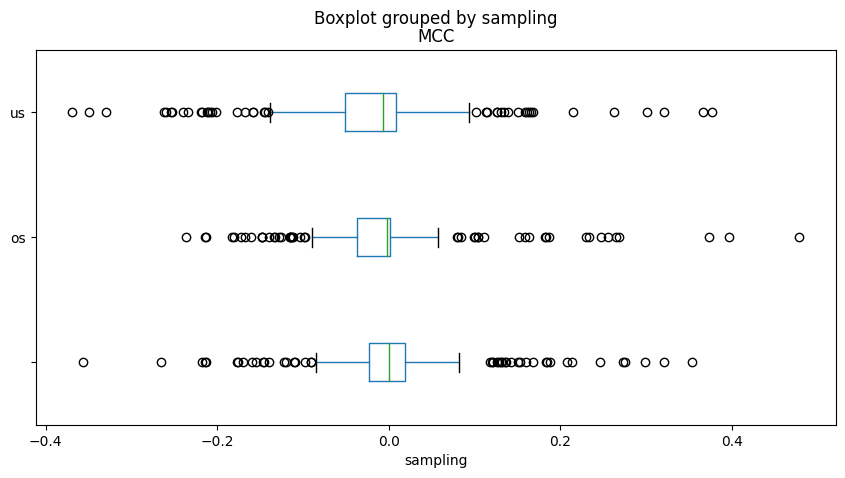

In [28]:

to_plot = data[["origin", "sampling", "Target", "Model", "MCC"]]
to_plot.boxplot(by="sampling", column=["MCC"], grid=False, figsize=(10, 5), vert=False)
plt.show()

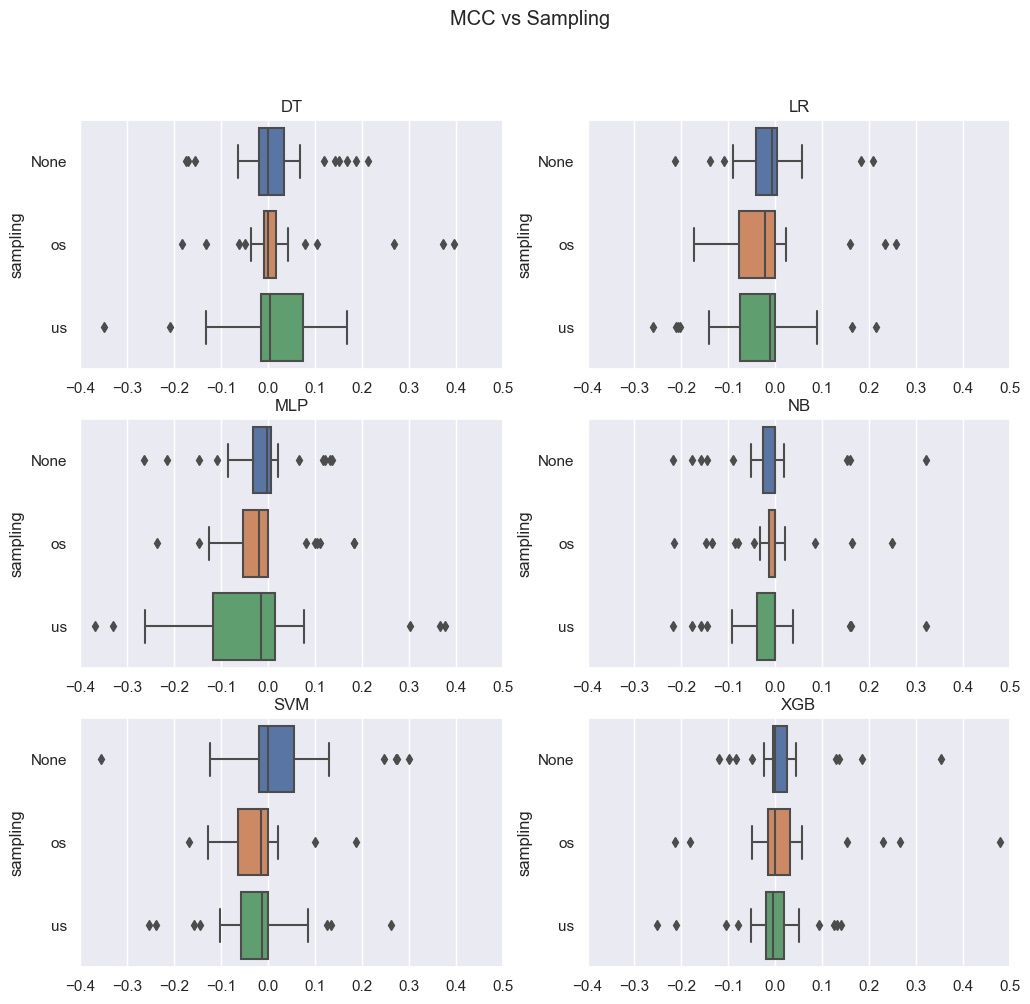

In [77]:
sns.set(rc={"figure.figsize":(12, 11)})

models = to_plot.Model.unique().tolist()
fig, axis = plt.subplots((len(models)+1)//2,2)
fig.suptitle('MCC vs Sampling')
axis = axis.reshape(-1)
for ax, model in zip(axis, models):
    plt.setp(ax, xlim=(-0.4, 0.5))
    boxplot = sns.boxplot(data=to_plot[to_plot.Model == model], x="MCC", y="sampling", ax=ax)
    boxplot.set_title(model)
    boxplot.set_xlabel(None)
    boxplot.set_yticklabels([plt.Text(0, 0, 'None'), plt.Text(0, 1, 'os'), plt.Text(0, 2, 'us')])
plt.savefig(filepath+'MCC_vs_sampling.png')